In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.stats import pearsonr
from matplotlib import colormaps

In [2]:
gene_1=pd.read_csv('../data/raw/gene_1.txt',delimiter='\t', low_memory=False)

In [3]:
gene_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Columns: 1449 entries, Sample to Expression
dtypes: float64(1448), object(1)
memory usage: 8.6+ MB


In [4]:
gene_1.head()

,Sample,15-45976702-45977052,15-45982813-45983160,15-45983175-45983347,15-45995910-45996255,15-45996259-45996428,15-45996456-45996764,15-45996819-45996987,15-45997063-45997254,15-45997416-45997635,...,15-49315529-49315877,15-49381258-49381604,15-50167700-50167901,15-50315097-50315414,15-50347957-50348141,15-50479039-50479260,15-48103367-48103714,15-49414124-49414471,15-49938148-49938496,Expression
0,IHECRE00001955,0.49830,0.71765,1.26255,0.21368,0.85358,0.63976,0.33459,0.00000,0.44695,...,0.63570,2.50192,0.76997,0.48920,0.48993,0.78117,1.52976,1.38009,0.34980,0.0
1,IHECRE00000227,2.92223,2.66952,2.69382,0.72047,0.46327,0.04019,0.34007,0.14549,4.55700,...,0.07586,0.70405,0.80722,0.00000,0.29017,0.74775,2.92270,1.44552,2.42589,0.0
2,IHECRE00001478,0.43758,0.32964,1.62194,0.31023,1.32639,1.71436,1.44638,2.78841,2.27327,...,2.04935,1.37250,1.03671,1.56793,2.95682,0.28493,0.90301,0.52811,1.60139,0.0
3,IHECRE00002337,2.23747,2.68867,0.73725,1.34511,2.90871,1.64011,0.71892,0.08026,0.46206,...,0.96743,0.12732,0.51818,2.09059,2.24160,0.58484,1.78445,0.79445,1.14262,0.0
4,IHECRE00001236,0.32554,0.49021,0.72664,3.13590,1.32609,1.42868,2.00968,1.87176,2.91399,...,0.45535,0.65087,1.82249,0.02572,0.77713,0.83902,2.72411,0.73362,0.91528,0.0


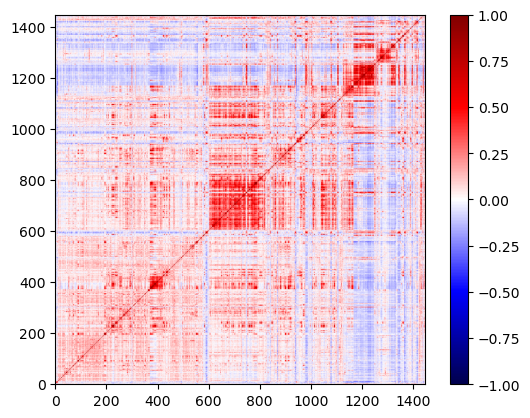

In [14]:
X = gene_1.iloc[:,1:-1]
corr = X.corr()
plt.imshow(corr, origin='lower', cmap=colormaps["seismic"], vmin=-1, vmax=1)
plt.colorbar()

Some adjacent genomic regions show high correlations. It might be worth running a clustering algorithm to combine some features in order to reduce the dimensionality of the feature space.

## Conversion to TPM, Log2 transform and investigate effect on distribution

Data is in FPKM (insert source). We should convert to TPM because we learned that it's better. 

Additionally we will log2(x+1) transform, because apparently that's best practise to get closer to the assumption of normal distributedness needed for linear regression, etc., see for example https://montilab.github.io/BS831/articles/docs/RNAseq_ScalNorm.html

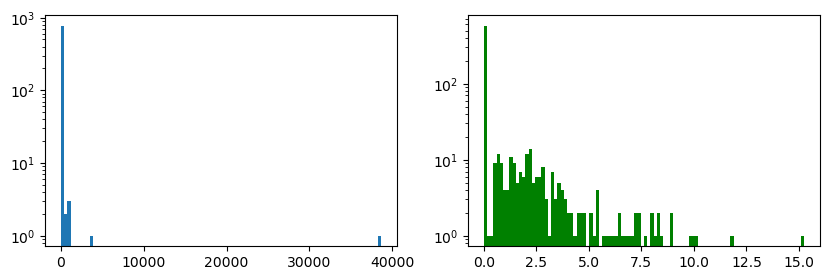

In [15]:
fig, axs=plt.subplots(1,2,figsize=(10,3))
axs[0].hist(gene_1['Expression'],bins=100)
axs[0].set_yscale('log')
axs[1].hist(np.log2(gene_1['Expression']+1), bins=100, color='g')
axs[1].set_yscale('log')
plt.show()

In [16]:
# log2 transform
gene_1['Expression']=np.log2(gene_1['Expression']+1)

## Splitting into training and test data for further analysis

In [17]:
X_train, X_test, Y_train, Y_test, idx_train, idx_test = sk.model_selection.train_test_split(gene_1.iloc[:,1:-1], gene_1.iloc[:,-1], np.arange(len(gene_1['Expression'])), test_size=0.3)

In [18]:
# z-score data
x_scaler=sk.preprocessing.StandardScaler()
y_scaler=sk.preprocessing.StandardScaler()

In [21]:
X_train=x_scaler.fit_transform(X_train)
X_test=x_scaler.transform(X_test)
Y_train=y_scaler.fit_transform(pd.DataFrame(Y_train))[:,0]
Y_test=y_scaler.transform(pd.DataFrame(Y_test))[:,0]

## Principal component analysis

We do this to check two things:

- do samples cluster by expression or not
- can we obtain the same or even improved accuary by using PCA as a feature selection method

In [22]:
PCA=sk.decomposition.PCA()

In [23]:
X_trans=PCA.fit_transform(X_train)

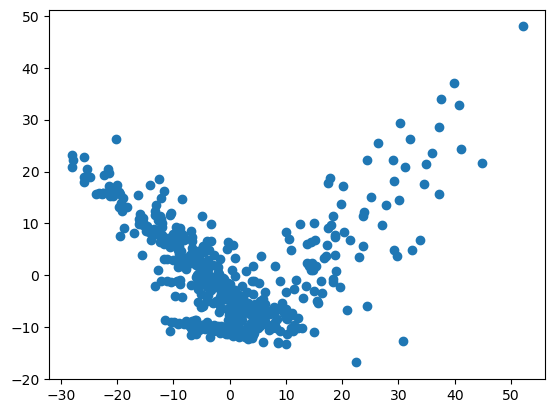

In [24]:
plt.scatter(X_trans[:,0], X_trans[:,1])

In [25]:
expl_var_ratio=PCA.explained_variance_ratio_

Text(0, 0.5, 'explained variance')

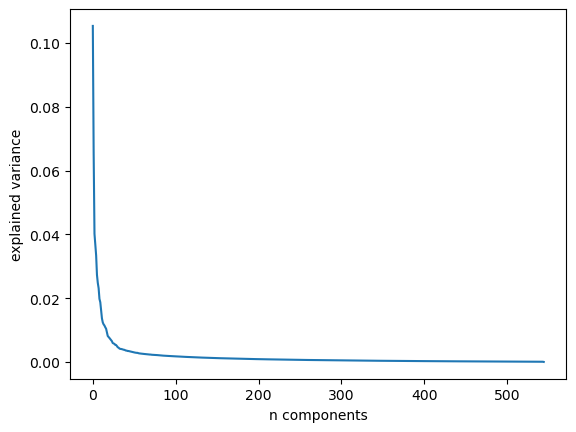

In [26]:
plt.plot(expl_var_ratio)
plt.xlabel("n components")
plt.ylabel("explained variance")
#plt.xlim(0,100)

In [27]:
print(expl_var_ratio[0:20])

[0.105338   0.06566206 0.04015635 0.0367456  0.03340319 0.02726938
 0.0247664  0.02310937 0.01976587 0.01872037 0.01627835 0.01364836
 0.01238872 0.01177437 0.01142949 0.01086985 0.01042239 0.00929286
 0.00813557 0.00783873]


Judging from this, it might be enough to keep only the first 20 principal components since the others explain less than 1% of variance.

In [28]:
X_pca=X_trans[:,0:20]

In [29]:
exp_or_not=gene_1.iloc[idx_train,-1]
exp_or_not=exp_or_not>0
print(len(exp_or_not))

545


Text(0, 0.5, 'PC 2')

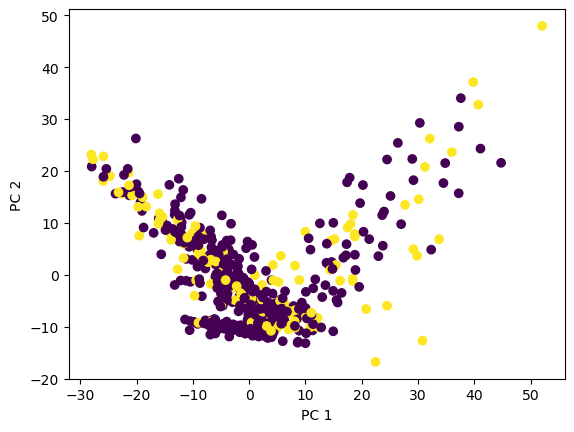

In [30]:
plt.scatter(X_pca[:,0], X_pca[:,1],c=exp_or_not)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

Conclusion: no visible clustering by whether the gene is expressed in a sample at all or not.

## 1 Baseline: Elastic net with all features

In [31]:
param_grid = {
 "alpha": [0.01, 0.1, 0.2, 0.5, 1],
 "l1_ratio": [0.5, 0.7, 0.9, 1.0]
}
elastic_net=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher=sk.model_selection.GridSearchCV(elastic_net, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [32]:
grid_searcher.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",ElasticNet(fi...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'alpha': [0.01, 0.1, ...], 'l1_ratio': [0.5, 0.7, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the sc

In [33]:
results=grid_searcher.cv_results_

In [34]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [35]:
df.sort_values('rank_test_score', axis=0)

,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,std_test_score,rank_test_score
5,0.012395,0.10,0.7,-0.813950,0.133315,1
4,0.010779,0.10,0.5,-0.818551,0.128306,2
6,0.009792,0.10,0.9,-0.819188,0.131570,3
8,0.009734,0.20,0.5,-0.822362,0.132081,4
7,0.009332,0.10,1.0,-0.824692,0.130214,5
9,0.009216,0.20,0.7,-0.844765,0.136658,6
10,0.008406,0.20,0.9,-0.870154,0.142734,7
11,0.007763,0.20,1.0,-0.884285,0.145323,8
3,0.037119,0.01,1.0,-0.900911,0.088149,9
2,0.042047,0.01,0.9,-0.904274,0.088378,10


In [36]:
best_estimator=grid_searcher.best_estimator_

In [37]:
# to see how many nonzero coefficients remain
print(np.sum(best_estimator.coef_!=0))
print(len(best_estimator.coef_))

50
1447


Text(0.5, 1.0, 'Sorted feature importances')

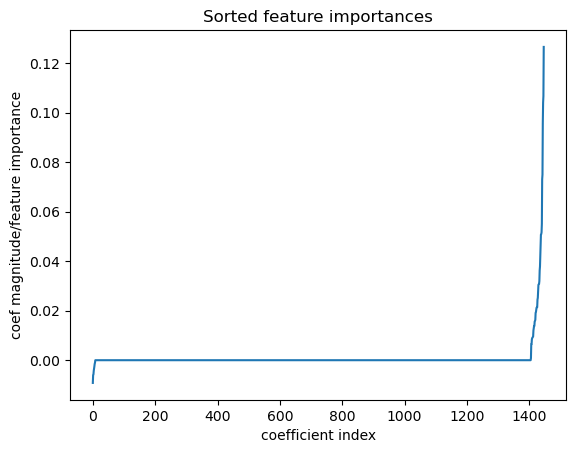

In [40]:
plt.plot(np.sort(best_estimator.coef_))
plt.xlabel("coefficient index")
plt.ylabel("coef magnitude/feature importance")
plt.title("Sorted feature importances")

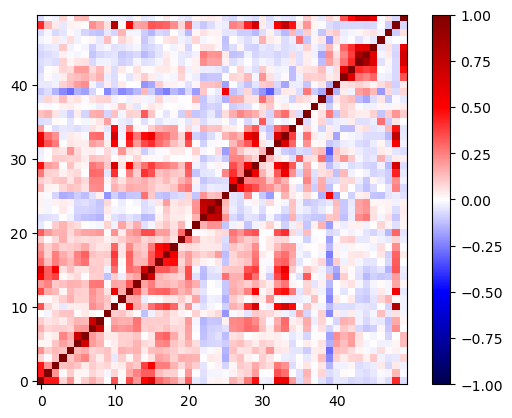

In [64]:
feature_mask = best_estimator.coef_ != 0
X_reduced = X.iloc[:,feature_mask]
corr = X_reduced.corr()
plt.imshow(corr, origin = 'lower', cmap = colormaps["seismic"], vmin=-1, vmax=1)
plt.colorbar()

Clusters of highly correlated genes remain even after the natural feature selection via elasticnet

In [44]:
Y_pred = best_estimator.predict(X_test)

In [46]:
elastic_net_score=best_estimator.score(X_test, Y_test)
print(elastic_net_score)

0.31491827457735744


In [48]:
MSE=sk.metrics.mean_squared_error(Y_test, Y_pred)

In [50]:
print(np.sqrt(MSE))

1.072257980825559


Text(0.5, 0, 'sample idx')

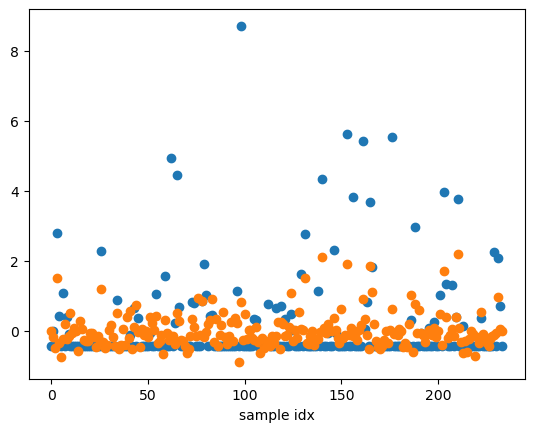

In [52]:
plt.scatter(np.arange(len(Y_test)),Y_test, label='Y_test')
plt.scatter(np.arange(len(Y_pred)),Y_pred, label='Y_pred')
plt.xlabel('sample idx')

Text(0, 0.5, 'Y_pred')

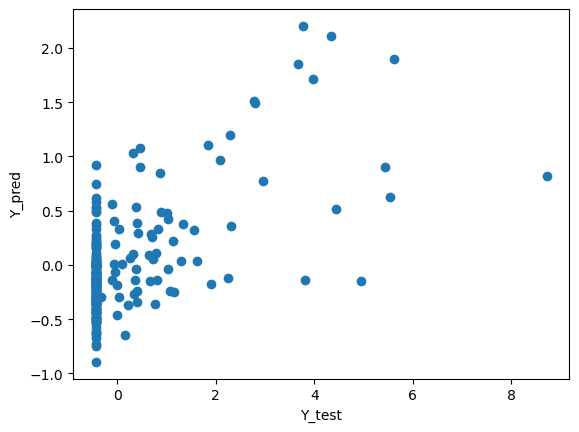

In [54]:
plt.scatter(Y_test,Y_pred)
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [56]:
elastic_net_corr=pearsonr(Y_test, Y_pred)
print(elastic_net_corr)

PearsonRResult(statistic=np.float64(0.6168611310834282), pvalue=np.float64(6.323038466858647e-26))


## 2 Elastic net with first 20 PCs

In [57]:
elastic_net_2=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher_2=sk.model_selection.GridSearchCV(elastic_net_2, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [58]:
grid_searcher_2.fit(X_pca, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",ElasticNet(fi...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'alpha': [0.01, 0.1, ...], 'l1_ratio': [0.5, 0.7, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the sc

In [59]:
best_estimator_2=grid_searcher_2.best_estimator_

In [60]:
results=grid_searcher_2.cv_results_

In [65]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [66]:
df.sort_values('rank_test_score', axis=0)

,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,std_test_score,rank_test_score
11,0.000339,0.20,1.0,-0.853945,0.143215,1
10,0.000331,0.20,0.9,-0.854084,0.141295,2
12,0.000336,0.50,0.5,-0.854217,0.148345,3
13,0.000345,0.50,0.7,-0.855811,0.149977,4
9,0.000346,0.20,0.7,-0.856488,0.135172,5
8,0.000375,0.20,0.5,-0.859656,0.128738,6
7,0.000344,0.10,1.0,-0.860075,0.128240,7
14,0.000366,0.50,0.9,-0.860712,0.151630,8
6,0.000349,0.10,0.9,-0.861268,0.126773,9
15,0.000358,0.50,1.0,-0.864327,0.152768,10


In [67]:
X_test_pca=PCA.transform(X_test)
X_test_pca=X_test_pca[:,0:20]

In [68]:
Y_pred = best_estimator_2.predict(X_test_pca)

In [69]:
elastic_net_score=best_estimator.score(X_test, Y_test)
print(elastic_net_score)

0.31491827457735744


In [71]:
MSE=sk.metrics.mean_squared_error(Y_test, Y_pred)
print(np.sqrt(MSE))

1.1098685578058758


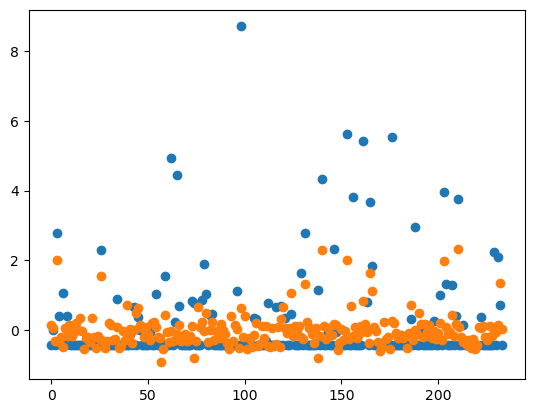

In [72]:
plt.scatter(np.arange(len(Y_test)),Y_test)
plt.scatter(np.arange(len(Y_pred)),Y_pred)

Conclusion: slightly worse performance keeping only the first 20 PCs but difference is so small that it might be worth investigating as a feature selection method for training with neural networks.

## Gradient boosting

In [73]:
gb_regressor=sk.ensemble.GradientBoostingRegressor()

In [74]:
gb_regressor.fit(X_train, Y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [80]:
Y_pred=gb_regressor.predict(X_test)

In [81]:
gb_score=gb_regressor.score(X_test,Y_test)
print(gb_score)

0.40930001407087857


In [82]:
gb_MSE=sk.metrics.mean_squared_error(Y_test,Y_pred)

In [83]:
print(gb_MSE)

0.9913411923510842


In [84]:
gb_corr=pearsonr(Y_test, Y_pred)
print(gb_corr)

PearsonRResult(statistic=np.float64(0.6428950810931592), pvalue=np.float64(1.1042024132840193e-28))


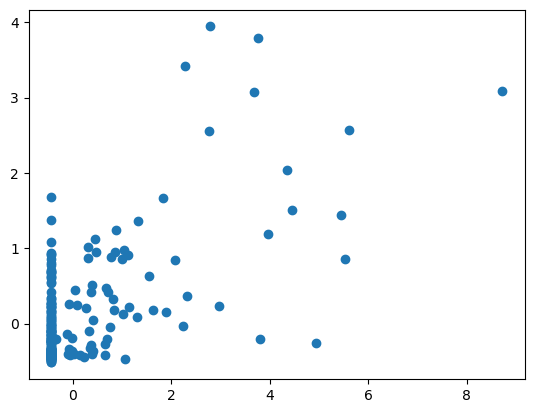

In [85]:
plt.scatter(Y_test,Y_pred)

Text(0, 0.5, 'importance')

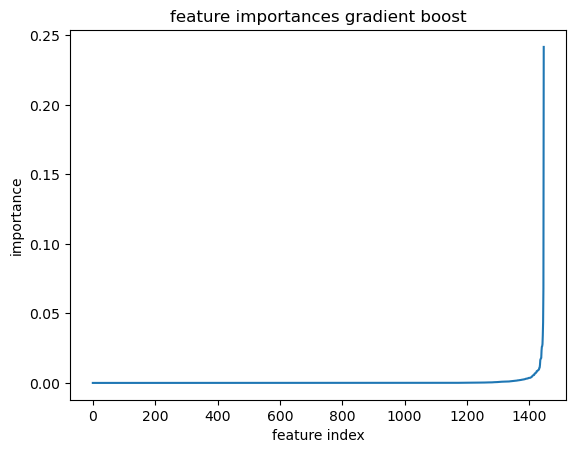

In [87]:
plt.plot(np.sort(gb_regressor.feature_importances_))
plt.title("feature importances gradient boost")
plt.xlabel("feature index")
plt.ylabel("importance")

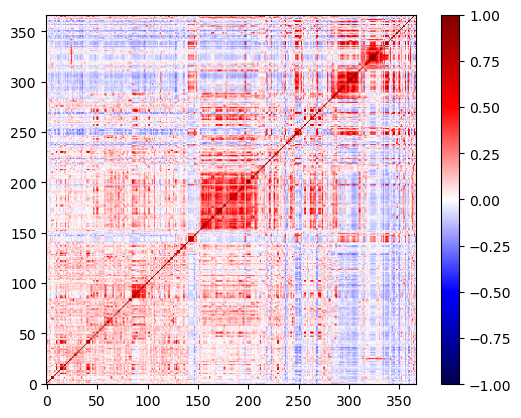

In [88]:
feature_mask = gb_regressor.feature_importances_ !=0
X_reduced = X.iloc[:,feature_mask]
corr = X_reduced.corr()
plt.imshow(corr, origin = 'lower', cmap = colormaps["seismic"], vmin=-1, vmax=1)
plt.colorbar()

Kept more features than elasticnet, just like elasticnet highly correlated ones remain

Conclusion: gradient boosting does slighlty better than elastic net, definitely worth investigating in controlled experiments, other nonlinear/distribution-distribution free methods.

## Hyperparameter tuning on gradient boosting

In [222]:
param_grid = {
 "learning_rate": [0.05, 0.1, 0.2],
 "n_estimators": [100, 200],
 "max_depth": [1, 5, 10, 20, 50]
}
gb_regressor=sk.ensemble.GradientBoostingRegressor()
grid_searcher=sk.model_selection.GridSearchCV(gb_regressor, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [ ]:
'''
CAUTION, executing this cell took me 3 hours to finish, 
for best model, see txt file with parameters in results folder
'''

grid_searcher.fit(X_train, Y_train)

In [225]:
results=grid_searcher.cv_results_

In [229]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_learning_rate', 'param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
df.sort_values('rank_test_score', axis=0)

In [231]:
best_estimator=grid_searcher.best_estimator_

In [232]:
Y_pred=best_estimator.predict(X_test)

In [ ]:
score=best_estimator.score(X_test, Y_test)
print(score)

In [ ]:
MSE=sk.metrics.mean_squared_error(Y_pred, Y_test)
print(MSE)

In [ ]:
corr_coeff=pearsonr(Y_test,Y_pred)
print(corr_coeff)

In [ ]:
plt.scatter(Y_test,Y_pred)

In [ ]:
plt.scatter(np.arange(len(Y_test)),Y_test)
plt.scatter(np.arange(len(Y_pred)), Y_pred)

In [ ]:
df.to_csv('../results/gradient_boost_gridsearchcv.txt', sep='\t')

In [90]:
tuning_results = pd.read_csv("../results/gradient_boost_gridsearchcv.txt", sep='\t')
tuning_results

,Unnamed: 0,mean_fit_time,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,0,8.891746,0.05,100,1,-0.831500,0.185709,11
1,1,17.792244,0.05,200,1,-0.804657,0.158749,5
2,2,41.933173,0.05,100,5,-0.822682,0.140867,6
3,3,83.703685,0.05,200,5,-0.838171,0.140524,12
4,4,78.217759,0.05,100,10,-0.929775,0.178077,14
5,5,150.847266,0.05,200,10,-0.939923,0.177809,16
6,6,144.976282,0.05,100,20,-1.020799,0.121836,21
7,7,279.040222,0.05,200,20,-1.033939,0.099596,25
8,8,224.241212,0.05,100,50,-1.031249,0.110988,23
9,9,446.028043,0.05,200,50,-1.037179,0.106459,26


## K-means clustering

To see whether there are obvious clusters and it might be worth trying a mixture-of-experts-model

In [91]:
k_means=sk.cluster.KMeans(n_clusters=3)

In [92]:
clusters=k_means.fit_predict(Y_train.reshape(-1,1))

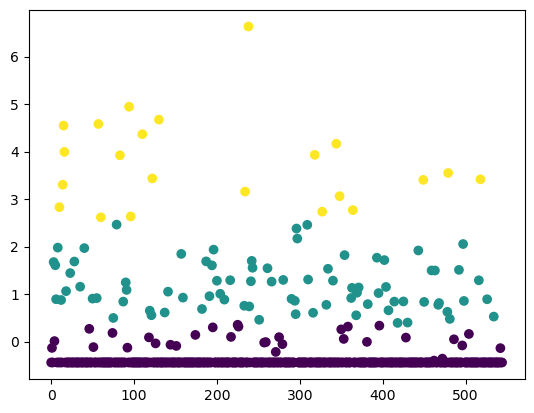

In [93]:
plt.scatter(np.arange(len(Y_train)),Y_train,c=clusters)

In [94]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = sk.cluster.KMeans(n_clusters=k, random_state=42).fit(Y_train.reshape(-1,1))  
    inertias.append(kmeanModel.inertia_)
    mapping2[k] = inertias[-1]

Inertia values:
1 : 545.0000000000003
2 : 152.75726100494697
3 : 48.48546910840629
4 : 28.19457871805816
5 : 19.611980451151318
6 : 13.477745875379034
7 : 8.286219549689672
8 : 6.376668105137061
9 : 4.397529544236436


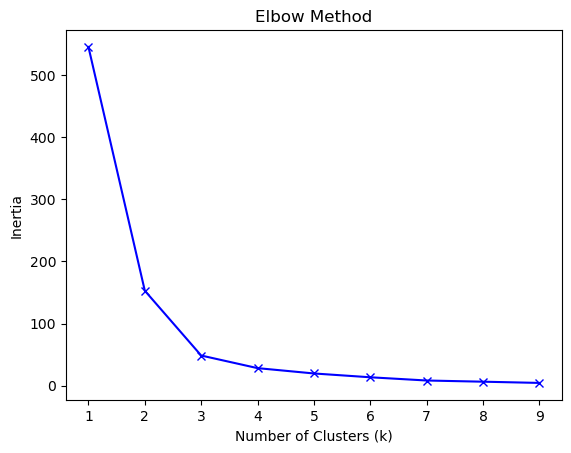

In [95]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()